In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import datetime 



from bqplot import pyplot as plt

def create_bqplot(y_test, y_pred , title):
    
    fig = plt.figure(title=title)

    options = {'x':{'label':"Date"}, 'y':{'label':'Close Price'}}

    scat = plt.plot(y_test.index, y_test.values* std_y + mean_y,
                       colors=["blue"],
                       axes_options = options,
                       stroke="black", stroke_width=2.0,
                       default_size=150,
                       default_opacities=[0.7],
                       marker="square", labels=['Actual Price'], legend_location= {"bottom"},display_legend=True 
                       )

    scat = plt.plot(y_test.index, y_pred* std_y + mean_y,
                       colors=["green"],
                       axes_options = options,
                       stroke="black", stroke_width=2.0,
                       default_size=150,
                       default_opacities=[0.7],
                       marker="circle", labels=['Predicted Price'],legend_location= {"bottom"}, display_legend=True
                       )

    fig.legend_style = {
        'fill': ''  ,
        'stroke' : '0' ,
        'stroke-width':3,
        'opacity':0.7   , 
        'stroke-width': 0
                      }
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    
    plt.show()
    return fig 
    

def create_X_data(lag, Dates):
    rows_list = []
    
    for i in range(len(Dates)):
        x_date = Dates[i]-  datetime.timedelta(days=lag)
        new_df = boyd.loc[x_date : x_date+ datetime.timedelta(days=lag-1)] 

        c_window = new_df[casino_features][0 :lag]
        t_window = new_df[tech_features][0 :lag].dropna()

        ans = []
        for col in casino_features:
            ans.append(np.array(c_window[col]).squeeze())

        c_ans = np.concatenate(ans)

        ans = []
        for col in tech_features:
            ans.append(np.array(t_window[col]).squeeze())

        t_ans = np.concatenate(ans)
        
        vector = np.concatenate((c_ans, t_ans), axis=None)
        vector = vector.astype('float')
        
        assert not np.isnan(np.sum(vector))
        
        rows_list.append(list(vector))
        
        
    X_df = pd.DataFrame(rows_list, index = Dates)
    
    return X_df, rows_list



# Reading stock and footfall data


In [2]:
#Get the data of the stock
start_date = '2018-03-05'
end_date = '2020-08-16'

boyd = yf.download('BYD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)

from ta import add_all_ta_features

a = add_all_ta_features(boyd, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
boyd = boyd[["trend_macd", 'momentum_rsi',"Volume" , "Adj Close"]]

footfall = pd.read_csv("casino.csv", names = ['Date', 'Casino1','Casino2','Casino3','Casino4','Casino5','Casino6','Casino7','Casino8','Casino9']) 
footfall = footfall.iloc[5:]

Date = footfall["Date"]
footfall = footfall.drop(["Date"], axis=1)
footfall.index = pd.date_range('20180305', '20200816')
footfall = footfall.astype('int')
footfall["total_foot"] = footfall.sum(axis = 1)
footfall = footfall.drop(['Casino1','Casino2','Casino3','Casino4','Casino5','Casino6','Casino7','Casino8','Casino9'], axis=1)

boyd = boyd.merge(footfall, left_index=True, right_index=True, how='right')

casino_features = ["total_foot"]
tech_features = ["trend_macd", 'momentum_rsi',"Volume"]

boyd.head(10)

/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,trend_macd,momentum_rsi,Volume,Adj Close,total_foot
2018-03-05,0.000000,100.000000,1003700.0,34.671322,3619
2018-03-06,0.028718,100.000000,1166400.0,35.025013,4385
2018-03-07,0.062856,100.000000,1097800.0,35.172375,4354
2018-03-08,0.081707,83.323807,749100.0,35.083961,4749
2018-03-09,0.070816,51.479538,1789200.0,34.779392,5778
2018-03-10,NaN,NaN,NaN,NaN,5602
2018-03-11,NaN,NaN,NaN,NaN,5070
2018-03-12,-0.018297,22.116384,2354100.0,33.796925,4283
2018-03-13,-0.170868,13.495214,2500100.0,32.775154,4286
2018-03-14,-0.248571,28.022092,1757100.0,33.266396,4563


# Doing holidays adjustment


In [3]:

y = boyd["Adj Close"][7:]
Dates = boyd.index[7:]
n_weeks = 0 
for i in range(0,len(Dates),7):
    week = 7 
    x_date = Dates[i] -  datetime.timedelta(days=week)
    new_df = boyd.loc[x_date : x_date + datetime.timedelta(days=week-3)]
    new_df = new_df.fillna(method='ffill')
    new_df = new_df.fillna(method='bfill')
    if sum(new_df.isna().sum()) != 0:
        print("Nan value not getting filled")
        print(i)
    boyd.update(new_df)
    n_weeks = n_weeks + 1 

In [4]:
boyd.shape

(896, 5)

# Creating the input feature vectors 

In [5]:
Dates = boyd.index[7:]
lag = 7
X_df , rows_list =create_X_data(lag,Dates)
# assert not np.sum(X_df.isna().sum())
# assert (n_weeks*2 == y.isna().sum())

In [6]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2018-03-12,3619.0,4385.0,4354.0,4749.0,5778.0,5602.0,5070.0,0.000000,0.028718,0.062856,...,100.000000,100.000000,100.000000,83.323807,51.479538,1003700.0,1166400.0,1097800.0,749100.0,1789200.0
2018-03-13,4385.0,4354.0,4749.0,5778.0,5602.0,5070.0,4283.0,0.028718,0.062856,0.081707,...,100.000000,100.000000,83.323807,51.479538,22.116384,1166400.0,1097800.0,749100.0,1789200.0,2354100.0
2018-03-14,4354.0,4749.0,5778.0,5602.0,5070.0,4283.0,4286.0,0.062856,0.081707,0.070816,...,100.000000,83.323807,51.479538,22.116384,13.495214,1097800.0,749100.0,1789200.0,2354100.0,2500100.0
2018-03-15,4749.0,5778.0,5602.0,5070.0,4283.0,4286.0,4563.0,0.081707,0.070816,-0.018297,...,83.323807,51.479538,22.116384,13.495214,28.022092,749100.0,1789200.0,2354100.0,2500100.0,1757100.0
2018-03-16,5778.0,5602.0,5070.0,4283.0,4286.0,4563.0,5271.0,0.070816,-0.018297,-0.170868,...,51.479538,22.116384,13.495214,28.022092,22.042528,1789200.0,2354100.0,2500100.0,1757100.0,1278000.0


In [7]:
merged_df =X_df.merge(y, left_index=True, right_index=True, how='inner')

merged_df = merged_df.dropna()


X = merged_df[X_df.columns.values]
y = merged_df['Adj Close']

# Run a linear regression model to predict the stock price 


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [12]:
X_new = X.iloc[:,7:] 
y_new = y 

split = 0.95
X_train = X_new[:int(len(X_new)*split)]
X_test = X_new[int(len(X_new)*split):]
y_train = y_new[:int(len(X_new)*split)]
y_test = y_new[int(len(X_new)*split):]


#Standardizing the data 
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y)/std_y
y_test = (y_test - mean_y)/std_y


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred), model.score(X_test,y_test)


(0.3533001721843828, -0.4406218734463845)

In [13]:
from bqplot import pyplot as plt
title = "Linear Regression Price Prediction without Footfall "
fig = create_bqplot(y_test, y_pred, title)

In [14]:
fig.save_png(title + ".png")

In [16]:
# from yellowbrick.regressor import PredictionError, ResidualsPlot
# viz = ResidualsPlot(model)
# viz.fit(X_train,y_train)
# viz.score(X_test,y_test)

Number of Trades: 34
Time Frame: 43 days
Profit: $376.98 | 7.54%


/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


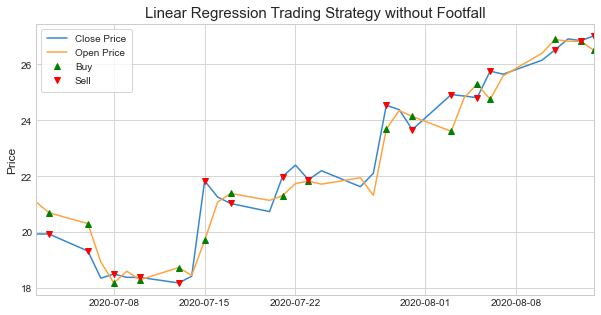

Sharpe Ratio is : 1.116929852699588


In [17]:
from matplotlib import pyplot as plt
#Trading Strategy 

boyd = yf.download('BYD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pred_dates = y_test.index
open_price = boyd.loc[pred_dates[0]:]["Open"]
y_predicted = y_pred* std_y + mean_y

stock = pd.DataFrame(open_price, index = pred_dates)
stock['Predicted_Close'] = y_predicted
stock['Close'] = y_test * std_y + mean_y
stock["Date"] = stock.index
stock.loc[stock.index[0],'Predicted_Close'] = stock.loc[stock.index[0],'Open'] - 1 

stock['returns_pred']  = stock.Predicted_Close.pct_change()
stock['signal'] = np.where(stock['returns_pred']>0 , 1, 0)
stock['Best_signal'] = np.where(stock['Close']>stock['Open'] , 1, 0)
stock = stock.interpolate()
profit , net = long_only_trading(stock,'signal' ,"Linear Regression Trading Strategy without Footfall",5000, True, True  )

#Finding sharpe Ratio 
stock['returns_pred']  = stock.Predicted_Close.pct_change()
stock['excess_daily_ret'] = stock['returns_pred'] - 0.05/252
sharpe = np.sqrt(30) * stock['excess_daily_ret'].mean() / stock['excess_daily_ret'].std()
print("Sharpe Ratio is : "+ str(sharpe) )



# Lasso Regression model 

In [18]:
thr = [i for i in np.arange(0.0001,1 , 0.05)]
for k in thr: 
    model = Lasso(k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mean_squared_error(y_test, y_pred), model.score(X_test,y_test)

/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.52238016204436, tolerance: 0.06029999999999997
  positive)


In [20]:
model = Lasso(0.0028)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred), model.score(X_test,y_test)

(0.33883665830365417, -0.38164524081514184)

In [21]:
from bqplot import pyplot as plt
title = "Lasso Model Price Prediction with alpha = 0.01 without Footfall"
fig = create_bqplot(y_test, y_pred, title)

In [22]:
fig.save_png(title + ".png")

Number of Trades: 32
Time Frame: 43 days
Profit: $376.98 | 7.54%


/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


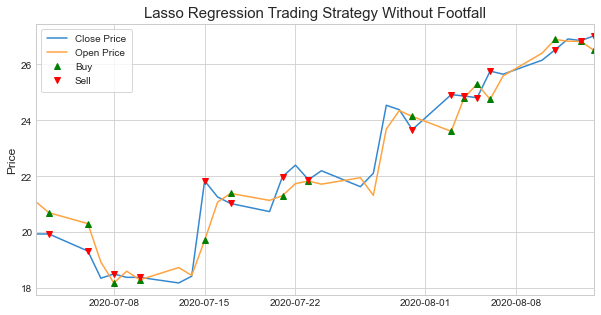

Sharpe Ratio is : 1.1501139526604949


In [23]:
from matplotlib import pyplot as plt
#Trading Strategy 
boyd = yf.download('BYD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pred_dates = y_test.index
open_price = boyd.loc[pred_dates[0]:]["Open"]
y_predicted = y_pred* std_y + mean_y

stock = pd.DataFrame(open_price, index = pred_dates)
stock['Predicted_Close'] = y_predicted
stock['Close'] = y_test * std_y + mean_y
stock["Date"] = stock.index
stock.loc[stock.index[0],'Predicted_Close'] = stock.loc[stock.index[0],'Open'] - 1 

stock['returns_pred']  = stock.Predicted_Close.pct_change()
stock['signal'] = np.where(stock['returns_pred']>0 , 1, 0)
stock['Best_signal'] = np.where(stock['Close']>stock['Open'] , 1, 0)
stock = stock.interpolate()
profit , net = long_only_trading(stock,'signal' ,"Lasso Regression Trading Strategy Without Footfall",5000, True, True  )

#Finding sharpe Ratio 
stock['returns_pred']  = stock.Predicted_Close.pct_change()
stock['excess_daily_ret'] = stock['returns_pred'] - 0.05/252
sharpe = np.sqrt(30) * stock['excess_daily_ret'].mean() / stock['excess_daily_ret'].std()
print("Sharpe Ratio is : "+ str(sharpe) )



## NeuralNetworks

In [31]:
X_new = X.iloc[:,7:]
y_new = y


split = 0.96
X_train = X_new[:int(len(X_new)*split)]
X_test = X_new[int(len(X_new)*split):]
y_train = y_new[:int(len(X_new)*split)]
y_test = y_new[int(len(X_new)*split):]

#Standardizing the data 
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y)/std_y
y_test = (y_test - mean_y)/std_y

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500, alpha=1).fit(X_train, y_train)
y_pred_train = regr.predict(X_train)
y_pred = regr.predict(X_test)

print(regr.score(X_train, y_train), regr.score(X_test, y_test))
MSE_error = mean_squared_error(y_train, y_pred_train)
print('Train data Mean Squared Error is {}'.format(MSE_error))

MSE_error = mean_squared_error(y_test, y_pred)
print('Test data Mean Squared Error is {}'.format(MSE_error))


0.5538398946656897 -0.2501177932013696
Train data Mean Squared Error is 0.4461601053343106
Test data Mean Squared Error is 0.25223633620889174


In [32]:
from bqplot import pyplot as plt
title = "Neural Networks model Price Prediction without Footfall"
fig = create_bqplot(y_test, y_pred, title)

In [33]:
fig.save_png(title + ".png")

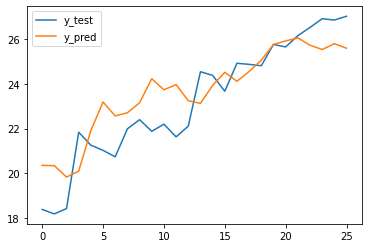

In [20]:
#plt.plot(y_train)
plt.plot(y_test.values* std_y + mean_y, label = "y_test")
plt.plot(y_pred* std_y + mean_y, label = "y_pred")
plt.legend()

## Long only Trading strategy - If signal is positive then buy at open and sell at close 

Number of Trades: 26
Time Frame: 35 days
Profit: $944.40 | 18.89%


/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


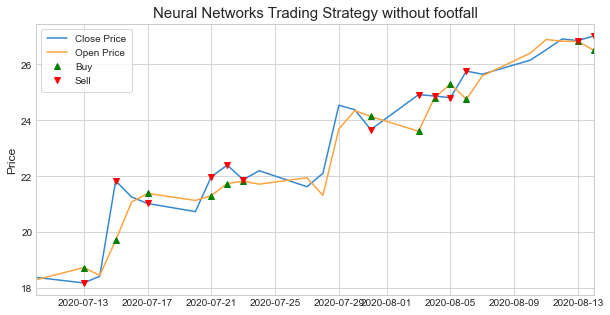

Sharpe Ratio is : 1.2926413481642134


In [34]:
from matplotlib import pyplot as plt

boyd = yf.download('BYD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pred_dates = y_test.index
open_price = boyd.loc[pred_dates[0]:]["Open"]
y_predicted = y_pred* std_y + mean_y

stock = pd.DataFrame(open_price, index = pred_dates)
stock['Predicted_Close'] = y_predicted
stock['Close'] = y_test * std_y + mean_y
stock["Date"] = stock.index
stock.loc[stock.index[0],'Predicted_Close'] = stock.loc[stock.index[0],'Open'] - 1 

stock['returns_pred']  = stock.Predicted_Close.pct_change()
stock['signal'] = np.where(stock['returns_pred']>0 , 1, 0)
stock['Best_signal'] = np.where(stock['Close']>stock['Open'] , 1, 0)

profit , net = long_only_trading(stock,'signal' ,"Neural Networks Trading Strategy without footfall",5000, True, True  )
#profit , net = long_only_trading(stock,'Best_signal' ,"Best possible Trading Strategy",5000, True, True )

#Finding sharpe Ratio 
stock['returns_pred']  = stock.Predicted_Close.pct_change()
stock['excess_daily_ret'] = stock['returns_pred'] - 0.05/252
sharpe = np.sqrt(30) * stock['excess_daily_ret'].mean() / stock['excess_daily_ret'].std()
print("Sharpe Ratio is : "+ str(sharpe) )



In [16]:
def long_only_trading(stock,signal,title,budget=15000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].Predicted_Close, stock.loc[0].Open)
    stock_amt = 0
    net = []
    
    for i in range(1, len(stock)):

        today = stock.iloc[i]
        if today[signal] == 1 : 
            #Buy at open price
            stock_amt = int(money / today.Open)
            money = 0
            net.append([today.Date, today.Open, 1, stock_amt * today.Close])
            
            
            #Sell at close price
            money = stock_amt * today.Close
            stock_amt = 0
            net.append([today.Date, today.Close, 0, money])
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - stock.loc[0].Date).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net,title )

    return profit, net    
    
    
    
def trading_history(stock, net,title, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Close Price')
    plt.plot(stock.index, stock.Open, color='#ffa33f', label='Open Price')
  
    plt.title(title, fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index[0], stock.index[-1]])
    
    for i in net:
        if i[2] == 1: 
            color = 'green'
            marker = '^'
        else: 
            color = 'red'
            marker = "v"
        plt.plot_date(i[0], i[1], color=color, marker = marker )
        
    plt.plot_date([],[],label='Buy', c='green', marker = '^')
    plt.plot_date([],[],label='Sell', c='red', marker = "v")
        
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.savefig("Plots/"+title + ".png")
    plt.show()